## 1. Molloy-Reed model

### (a) Given a random microstate generated based on the configuration model with degree distribution $P(k)$, consider a random node $v$ and follow a random edge to a neighbor $w$ of $v$. What is the probability that node $w$ has degree $k$?

So we choose the arbitrary node from the network, follow one of the links and check the chance that the degree of the successor node will be k. First of all the degree distribution will not be $P(k)$ because that $\langle k_{n} \rangle \geq 1$.
So, we have randomly chosen a node and stub on it to start the link to the neighbour. The probability to come to the node with $k$ degree is $\frac{k}{2m - 1}$. At the same time the degree distribution is calculated by formula: $P(k) = \frac{n_{k}}{n}$, where $n_{k}$ - number of nodes with with $k$ degree. So, $n_{k} = P(k)n$. So, the chance to come to the node with $k$ degree is:
$$P_{n}(k) = \frac{k}{2m - 1} np_{k}$$
At the same time for $n \rightarrow \infty$ we can neglect $-1$ in formula and simplify it:
$$P_{n}(k) = \frac{k}{2m}nP(k) = \frac{kP(k)}{\frac{2m}{n}} = \frac{kP(k)}{\langle k \rangle}$$

### (b) Using the expression obtained above compute the expected degree of the neighbors a random node $v$. What do we see when we calculate the difference between the expected degree of a random node and the expected degree of a random neighbor of such a node?

The formula for calculating the mean degree:
$$\langle k \rangle = \sum_{k = 0}^{\infty}kP(k)$$

For the neighbour degree we can use previously discovered formula:
$$P_{n}(k) = \frac{kP(k)}{\langle k \rangle}$$
$$\langle k_{n} \rangle = \sum_{k = 0}^{\infty} kP_{n}(k) = \frac{\sum_{k = 0}^{\infty} k^{2} P(k)}{\langle k \rangle} = \frac{\langle k^{2} \rangle}{\langle k \rangle}$$

The difference:
$$\langle k_{n} \rangle - \langle k \rangle = \frac{\langle k^{2} \rangle}{\langle k \rangle} - \langle k \rangle = \frac{\langle k^{2} \rangle - \langle k \rangle^{2}}{\langle k \rangle} = \frac{Var(k)}{\langle k \rangle} \geq 0$$

### (c) Often rather than the degree of a node at the end of an edge we are interested in the number of edges attached to the node other than the one we arrived through. This number is called the excess degree of a node and will play an important role in the coming lectures. What is the probability that the node at which you arrive has excess degree k?

Access degree of the node is the usual neighbour degree without one more edge. So the node with $k$ excess degree will have $k + 1$ degree. So the probability is:
$$Q(k) = \frac{(k + 1)P(k +1)}{\langle k \rangle}$$

## 2. Friendship paradox and generating functions

### (a) Consider a random network with a given log-normal degree distribution with parameters $\mu$ and $\sigma$. Use the Molloy-Reed model to generate microstates from this statistical ensemble and calculate the difference between the mean degree $\langle k \rangle$ and the mean neighbour degree $\langle k_{n} \rangle$. How dœs a change of parameters $\mu$ and $\sigma$ influence $\langle k \rangle$ compared to $\langle k_{n} \rangle?

In [10]:
import multiprocessing as mp
from typing import List, Tuple
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import pathpy as pp
from tqdm import tqdm
import matplotlib.pyplot as plt

In [30]:
%%time
def generate_network(mean_sima_pair: Tuple):
    mean, sigma = mean_sima_pair
    while True:
        random_degrees = [int(x)
                          for x in np.random.lognormal(mean=mean,
                                                       sigma=sigma,
                                                       size=300)]
        if pp.generators.is_graphic_Erdos_Gallai(random_degrees):
            return random_degrees

mean_sigma_pairs = [(mean, sigma)
                    for mean in np.arange(0.5, 1.5, 0.05)
                    for sigma in np.arange(0.25, 1.25, 0.2)]

with mp.Pool(mp.cpu_count()) as pool:
    generated_degrees = [i for i in tqdm(pool.imap_unordered(generate_network, mean_sigma_pairs), total=len(mean_sigma_pairs))]

100%|██████████| 100/100 [00:02<00:00, 43.19it/s]

CPU times: user 345 ms, sys: 83.6 ms, total: 429 ms
Wall time: 2.42 s


In [31]:
%%time
def get_network_and_params(degrees: List):
    current_network = pp.generators.Molloy_Reed(degrees)
    current_mean = current_network.mean_degree()
    current_neighbour_mean = current_network.mean_neighbor_degree()
    return current_mean, current_neighbour_mean


with mp.Pool(mp.cpu_count()) as pool:
    results = [i for i in tqdm(pool.imap_unordered(get_network_and_params, generated_degrees), total=len(generated_degrees))]

mean_arr, sigma_arr, means, neighbour_means, diffs = [], [], [], [], []

for mean, sigma in mean_sigma_pairs:
    mean_arr.append(mean)
    sigma_arr.append(sigma)

for mean, neighbour_mean in results:
    means.append(mean)
    neighbour_means.append(neighbour_mean)
    diffs.append(neighbour_mean - mean)

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]

CPU times: user 508 ms, sys: 110 ms, total: 619 ms
Wall time: 56.8 s


In [32]:
df = pd.DataFrame({
    'Mean': mean_arr,
    'Sigma': sigma_arr,
    '<k>': means,
    '<kn>': neighbour_means,
    '<kn> - <k>': diffs,
    })

df

,Mean,Sigma,<k>,<kn>,<kn> - <k>
0,0.50,0.25,1.226667,1.429348,0.202681
1,0.50,0.45,1.580000,3.046414,1.466414
2,0.50,0.65,1.380000,2.115942,0.735942
3,0.50,0.85,1.266667,1.457895,0.191228
4,0.50,1.05,2.326667,7.882521,5.555855
...,...,...,...,...,...
95,1.45,0.25,5.680000,14.694836,9.014836
96,1.45,0.45,4.786667,8.743733,3.957066
97,1.45,0.65,4.333333,5.720000,1.386667
98,1.45,0.85,6.086667,15.421687,9.335020


In this table we can observe the friendship paradox - when the mean degree(\<k\>) is smaller than the mean neighbor degree(\<kn\>). As we can judge, the friendship paradox is stronger with increasing mean and standard deviation. It happens because during enhancing the standard deviation, degree distribution becomes more scattered and hence some nodes will have much more connections than others. Since we have a mean defined for lognormal function, the degree of random nodes will be near this mean which we set for the lognormal function and will not change much with the deviation.

Text(0.5, 1.0, 'Difference between mean degree and mean neighbour degree depend on the standard deviation')

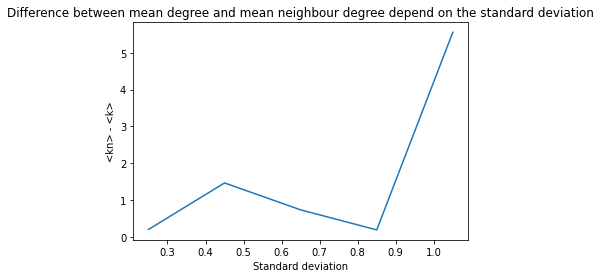

In [33]:
first_mean = df[df.Mean == 0.5]
plt.plot(first_mean.Sigma, first_mean['<kn> - <k>'])
plt.xlabel("Standard deviation")
plt.ylabel("<kn> - <k>")
plt.title("Difference between mean degree and mean neighbour degree depend on the standard deviation")

Text(0.5, 1.0, 'Difference between mean degree and mean neighbour degree depend on the mean degree')

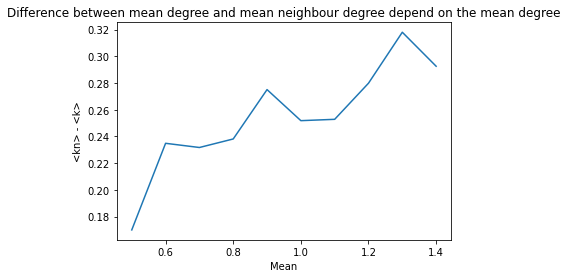

In [32]:
first_mean = df[df.Sigma == 0.25]
plt.plot(first_mean.Mean, first_mean['<kn> - <k>'])
plt.xlabel("Mean")
plt.ylabel("<kn> - <k>")
plt.title("Difference between mean degree and mean neighbour degree depend on the mean degree")

### (b) Consider a number sequence $\{a_{k}\}_{k=0}^{\infty}$. We call a power series $$F_{0}(x) = \sum_{k=0}^{\infty} a_{k} x^{k}$$ ### a generating function of the sequence $\{a_{k}\}_{k=0}^{\infty}$. Consider the sequence $\{b_{k}\}_{k=0}^{\infty}$ with $$\{b_{k}\}_{k=0}^{\infty} = \{a_{0}, 0, a_{2}, 0, \ldots\}$$ ### Specify a function $F_{1}(x)$ that generate $\{b_{k}\}_{k=0}^{\infty}$, where $F_{1}(x)$ is the expression is the terms of $F_{0}(x)$. Hint: consider the sequence generated by $F_{0}(-x)$.

Lets define that $$F_{0}(-x) = \sum_{k=0}^{\infty} a_{k} (-x)^{k} = \sum_{k=0}^{\infty} a_{2k} x^{2k} - \sum_{k=0}^{\infty} a_{2k + 1} x^{2k + 1}$$
So for even $k$ $F_{0}(x)$ and $F_{0}(-x)$ give same sum parts $a_{k}x^{k}$ and for not even - parts with different signs. So,
$$F_{0}(-x) + F_{0}(x) = 2\sum_{k=0}^{\infty} a_{2k} x^{2k} = 2\sum_{k=0}^{\infty}b_{k}x^{k} = 2 F_{1}(x)$$
$$F_{1}(x) = \frac{F_{0}(x) + F_{0}(-x)}{2}$$